In [1]:
import torch
import torchvision.models as models

# 加载预训练的ResNet-18模型
model = models.resnet18(pretrained=True)

# 如果你想要使用模型作为特征提取器，可以去掉最后一层（全连接层）
# ResNet的最后一个子模块通常是全连接层，负责分类输出
# 这里我们获取除了最后一层之外的所有层
features_extractor = torch.nn.Sequential(*list(model.children())[:-1])

# 确保模型在评估模式下运行，这样BatchNorm和Dropout层会处于正确状态
features_extractor.eval()

# 假设你有一个输入图像，这里我们创建一个随机的3x224x224图像
input_image = torch.randn(1, 3, 224, 224)

# 将图像通过特征提取器
with torch.no_grad():
    output_features = features_extractor(input_image)

# 输出特征图的尺寸
print("Output Features Shape:", output_features.shape)

/home/lihao/miniconda3/envs/detr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lihao/miniconda3/envs/detr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/lihao/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


Output Features Shape: torch.Size([1, 512, 1, 1])


In [3]:
output_features.shape

torch.Size([1, 512, 1, 1])

In [6]:
from typing import Optional
import torch
from torch import nn
from torchvision.models import resnet50
from torch import Tensor
class NestedTensor(object):
    def __init__(self, tensors, mask: Optional[Tensor]):
        self.tensors = tensors
        self.mask = mask

    def to(self, device):
        # type: (Device) -> NestedTensor # noqa
        cast_tensor = self.tensors.to(device)
        mask = self.mask
        if mask is not None:
            assert mask is not None
            cast_mask = mask.to(device)
        else:
            cast_mask = None
        return NestedTensor(cast_tensor, cast_mask)

    def decompose(self):
        return self.tensors, self.mask

    def __repr__(self):
        return str(self.tensors)


class IntermediateLayerGetter(nn.ModuleDict):
    """
    Module wrapper that returns intermediate layers from a model
    """
    def __init__(self, model, return_layers):
        super().__init__()
        self.body = model
        self.return_layers = return_layers
        # Set up the return layers
        for name in return_layers:
            self.add_module(name, nn.Identity())

    def forward(self, x):
        output = {}
        x = self.body(x)
        for name in self.return_layers:
            output[name] = x
        return output

class BackboneBase(nn.Module):
    def __init__(self, backbone, train_backbone, num_channels, return_interm_layers):
        super().__init__()
        for name, parameter in backbone.named_parameters():
            if not train_backbone or 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                parameter.requires_grad_(False)
        if return_interm_layers:
            return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
        else:
            return_layers = {'layer4': "0"}
        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.num_channels = num_channels

    def forward(self, tensor_list):
        xs = self.body(tensor_list.tensors)
        out = {}
        for name, x in xs.items():
            m = tensor_list.mask
            assert m is not None
            mask = torch.nn.functional.interpolate(m[None].float(), size=x.shape[-2:]).to(torch.bool)[0]
            out[name] = NestedTensor(x, mask)
        return out

# Example usage
def main():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    # Create a backbone network (ResNet50)
    backbone = resnet50(pretrained=True).to(device)
    
    # Create an instance of BackboneBase
    backbone_base = BackboneBase(backbone, True, 2048, True).to(device)
    
    # Generate some dummy input data
    batch_size = 2
    img_height = 224
    img_width = 224
    tensors = torch.randn(batch_size, 3, img_height, img_width, device=device)
    masks = torch.zeros((batch_size, img_height, img_width), dtype=torch.bool, device=device)
    for i in range(batch_size):
        h, w = torch.randint(100, 200, (2,))
        masks[i, :h, :w] = 1
    
    # Wrap tensors and masks into NestedTensor
    tensor_list = NestedTensor(tensors, masks)
    
    # Forward pass through the BackboneBase
    features = backbone_base(tensor_list)
    
    # Print the features
    for name, feature in features.items():
        print(f"Feature {name}: {feature.tensors.shape}")

main()

/home/lihao/miniconda3/envs/detr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lihao/miniconda3/envs/detr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/lihao/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


Feature layer1: torch.Size([2, 1000])
Feature layer2: torch.Size([2, 1000])
Feature layer3: torch.Size([2, 1000])
Feature layer4: torch.Size([2, 1000])


In [8]:
import torch
from torch.nn import functional as F

def resize_mask_to_feature_map(m, x):
    # 上采样掩码到特征图的尺寸
    resized_mask = F.interpolate(m[None].float(), size=x.shape[-2:], mode='nearest')
    # 转换为布尔类型
    bool_mask = resized_mask.to(torch.bool)[0]
    return bool_mask

# 创建一个示例掩码张量
original_mask = torch.tensor([
    [True, False, False],
    [False, True, True],
    [True, True, False]
], dtype=torch.bool)

# 创建一个示例特征图张量
feature_map = torch.rand(1, 3, 10, 10)  # 假设特征图的尺寸为 (1, 64, 10, 10)

# 将掩码上采样到特征图的尺寸
resized_mask = resize_mask_to_feature_map(original_mask, feature_map)

# 打印原始掩码和上采样的掩码
print("Original Mask:")
print(original_mask)
print("\nResized Mask:")
print(resized_mask)

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [3] and output size of torch.Size([10, 10]). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [9]:
import torch
from torch.nn import functional as F

def resize_mask_to_feature_map(m, x):
    # 确保掩码至少有4个维度 (N=1, C=1, H, W)
    m = m[None, None, ...]  # 相当于 m.unsqueeze(0).unsqueeze(0)
    
    # 上采样掩码到特征图的尺寸
    resized_mask = F.interpolate(m.float(), size=x.shape[-2:], mode='nearest')
    
    # 转换为布尔类型并移除额外的维度 (N和C)
    bool_mask = resized_mask.to(torch.bool).squeeze(0).squeeze(0)
    
    return bool_mask

# 示例掩码张量 (H, W)
original_mask = torch.tensor([
    [True, False, False],
    [False, True, True],
    [True, True, False]
], dtype=torch.bool)

# 示例特征图张量 (N, C, H', W')
feature_map = torch.rand(1, 64, 10, 10)

# 将掩码上采样到特征图的尺寸
resized_mask = resize_mask_to_feature_map(original_mask, feature_map)

# 打印结果
print("Original Mask Shape:", original_mask.shape)
print("Resized Mask Shape:", resized_mask.shape)

Original Mask Shape: torch.Size([3, 3])
Resized Mask Shape: torch.Size([10, 10])


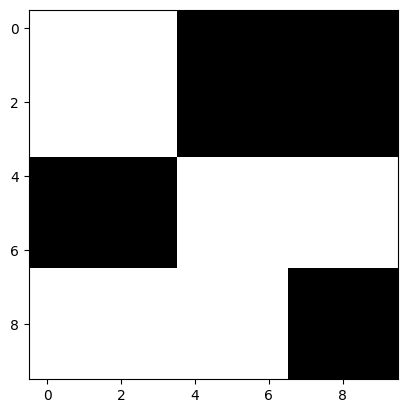

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制 resized_mask
def plot_resized_mask(resized_mask):
    plt.imshow(resized_mask, cmap='gray')

    plt.show()

plot_resized_mask(resized_mask)

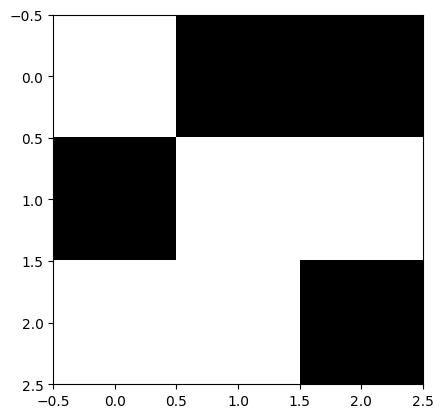

In [12]:
plot_resized_mask(original_mask)

In [9]:
import torch
import torch.nn as nn



class PositionEmbeddingLearned(nn.Module):
    """
    Absolute pos embedding, learned.
    """
    def __init__(self, num_pos_feats=256):
        super().__init__()
        self.row_embed = nn.Embedding(50, num_pos_feats)
        self.col_embed = nn.Embedding(50, num_pos_feats)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.row_embed.weight)
        nn.init.uniform_(self.col_embed.weight)

    def forward(self, tensor_list):
        x = tensor_list
        h, w = x.shape[-2:]
        i = torch.arange(w, device=x.device)
        j = torch.arange(h, device=x.device)
        x_emb = self.col_embed(i)
        y_emb = self.row_embed(j)
        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(h, 1, 1),
            y_emb.unsqueeze(1).repeat(1, w, 1),
        ], dim=-1).permute(2, 0, 1).unsqueeze(0).repeat(x.shape[0], 1, 1, 1)
        return pos

# 创建 PositionEmbeddingLearned 实例
position_embedding = PositionEmbeddingLearned(num_pos_feats=128)

# 假设我们有一个 batch size 为 2 的输入特征图，尺寸为 32x32，通道数为 512
input_tensor = torch.randn(1, 1, 32, 32)

# 将输入张量包装到 NestedTensor 中
nested_tensor = input_tensor

# 调用前向传播方法
pos_embedding = position_embedding(nested_tensor)

# 输出位置嵌入的形状
print(pos_embedding.shape)

torch.Size([1, 256, 32, 32])


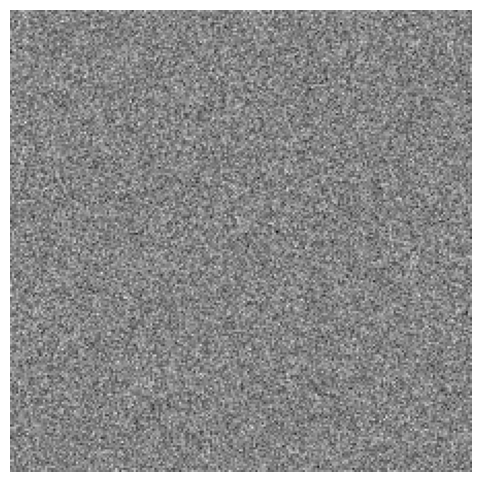

In [3]:
# a = torch.randn(1,1,224,224)
# plot_resized_mask(a[0])

import torch
import matplotlib.pyplot as plt

# 生成一个假的灰度图像张量
image_tensor = torch.randn(1, 224, 224)  # 假设是你的图像数据

# 转换张量为 numpy 数组，并去除批次维度
image_np = image_tensor.squeeze().numpy()

# 绘制图像
plt.figure(figsize=(6, 6))
plt.imshow(image_np, cmap='gray')  # 使用灰度颜色映射
plt.axis('off')
plt.show()


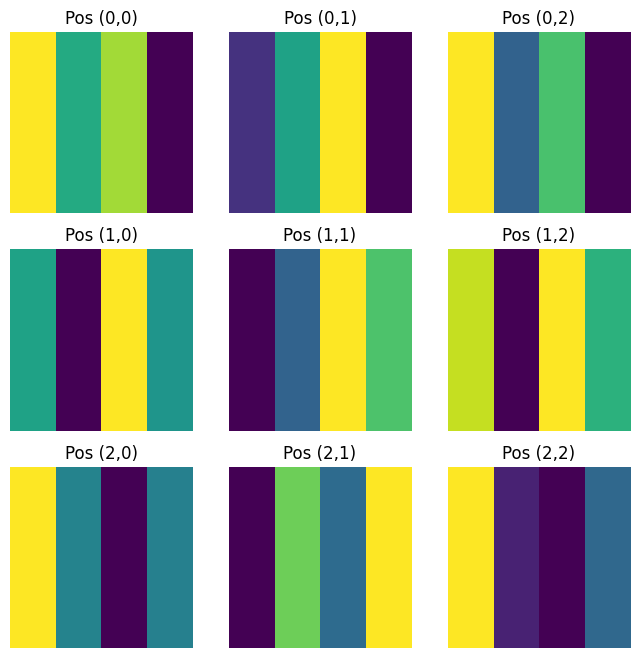

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class PositionEmbeddingLearned(nn.Module):
    def __init__(self, num_pos_feats=256, grid_size=50):
        super().__init__()
        self.row_embed = nn.Embedding(grid_size, num_pos_feats)
        self.col_embed = nn.Embedding(grid_size, num_pos_feats)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.row_embed.weight, -0.1, 0.1)
        nn.init.uniform_(self.col_embed.weight, -0.1, 0.1)

    def forward(self, height, width):
        i = torch.arange(width) # [0, ..., width-1]
        j = torch.arange(height) # [0, ..., height-1]
        x_emb = self.col_embed(i) # w x pos_feature
        y_emb = self.row_embed(j) # h x pos_feature
        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(height, 1, 1),
            y_emb.unsqueeze(1).repeat(1, width, 1),
        ], dim=-1)
        return pos

# 设置图像的大小为3x3，特征维度为2
embed_dim = 2
model = PositionEmbeddingLearned(num_pos_feats=embed_dim, grid_size=10)

# 获取位置编码
pos_embedding = model.forward(3, 3)

# 可视化位置编码
pos_embedding_np = pos_embedding.detach().numpy()

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i in range(3):
    for j in range(3):
        ax = axs[i, j]
        ax.imshow(np.tile(pos_embedding_np[i, j], (10, 1)), aspect='auto')
        ax.set_title(f'Pos ({i},{j})')
        ax.axis('off')

plt.show()


In [21]:

import torch
import torch.nn as nn
embed_lay = nn.Embedding(50, 3)
a = torch.arange(10)
b = torch.arange(10)
a_emb = embed_lay(a)
b_emb = embed_lay(b)

In [24]:
pos = torch.cat([
    a_emb.unsqueeze(0).repeat(10, 1, 1),
    b_emb.unsqueeze(1).repeat(1, 10, 1),
], dim=-1)

In [25]:
pos += 1

TypeError: Invalid shape (10, 10, 6) for image data

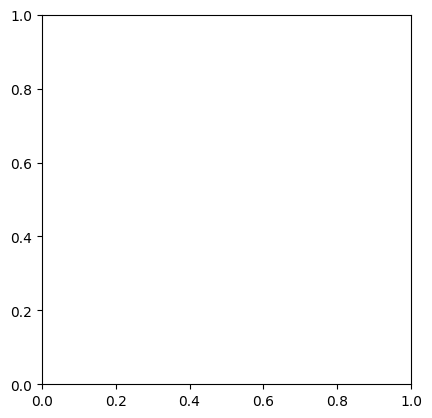

In [27]:
image_np = pos.detach().squeeze().numpy()
plt.imshow(image_np)

In [20]:
a = torch.tensor([1],dtype=torch.int32)
res = embed_lay(a)

In [19]:
res

tensor([[ 0.3283,  0.6993,  1.5480,  0.4346, -0.3219,  1.3430,  0.6944,  0.2911,
         -0.0227, -0.2946]], grad_fn=<EmbeddingBackward0>)

## 测试 transformer

In [30]:
import torch
import torch.nn as nn

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义模型参数
input_size = 512  # 输入维度（字嵌入维度）
num_layers = 6    # Transformer层数
num_heads = 8     # 注意力头数
dim_feedforward = 2048  # 前馈网络的维度

# 初始化模型
transformer_model = nn.Transformer(
    d_model=input_size,
    nhead=num_heads,
    num_encoder_layers=num_layers,
    num_decoder_layers=num_layers,
    dim_feedforward=dim_feedforward
).to(device)

# 创建一个示例输入 (序列长度, 批大小, 嵌入维度)
src = torch.rand((12, 1, input_size), device=device)  # 源序列
tgt = torch.rand((1, 1, input_size), device=device)  # 目标序列

# 前向传播
out = transformer_model(src, tgt)

print("Output shape:", out.shape)  # 应为 [20, 32, 512]


Output shape: torch.Size([1, 1, 512])


看到一个相关的演示：
[examples/word\_language\_model at main · pytorch/examples](https://github.com/pytorch/examples/tree/main/word_language_model)
[The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)


# 匈牙利算法，匹配二分图

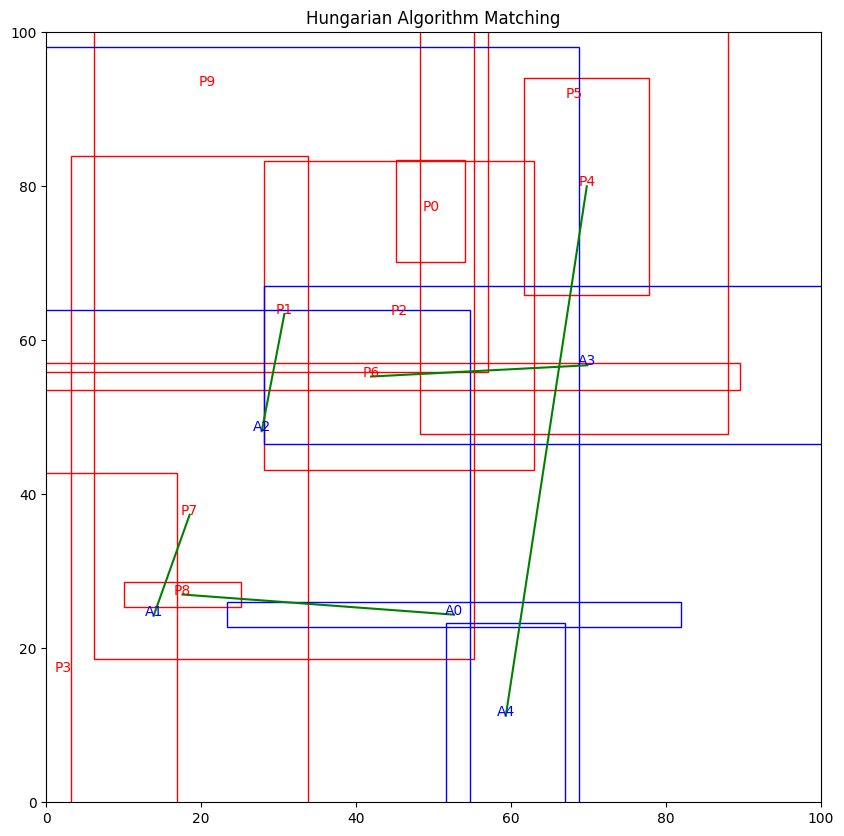

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import linear_sum_assignment

def box_cxcywh_to_xyxy(boxes):
    x_c, y_c, w, h = boxes.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

def generalized_box_iou(boxes1, boxes2):
    # Calculate intersection areas
    inter_x1 = torch.max(boxes1[:, None, 0], boxes2[:, 0])
    inter_y1 = torch.max(boxes1[:, None, 1], boxes2[:, 1])
    inter_x2 = torch.min(boxes1[:, None, 2], boxes2[:, 2])
    inter_y2 = torch.min(boxes1[:, None, 3], boxes2[:, 3])
    
    inter_area = (inter_x2 - inter_x1).clamp(min=0) * (inter_y2 - inter_y1).clamp(min=0)
    
    boxes1_area = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    boxes2_area = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    
    union_area = boxes1_area[:, None] + boxes2_area - inter_area
    
    return inter_area / union_area

class HungarianMatcher:
    def __init__(self, cost_class=1, cost_bbox=1, cost_giou=1):
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou

    def __call__(self, outputs, targets):
        out_bbox = outputs["pred_boxes"]
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)
        cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox), box_cxcywh_to_xyxy(tgt_bbox))
        C = self.cost_bbox * cost_bbox + self.cost_giou * cost_giou

        indices = linear_sum_assignment(C.cpu())
        return indices

# Generate random boxes [center_x, center_y, width, height]
torch.manual_seed(0)
predicted_boxes = torch.rand(10, 4) * 100
actual_boxes = torch.rand(5, 4) * 100

outputs = {"pred_boxes": predicted_boxes}
targets = [{"boxes": actual_boxes}]

matcher = HungarianMatcher(cost_bbox=1, cost_giou=1)
indices = matcher(outputs, targets)

plt.figure(figsize=(10, 10))
ax = plt.gca()

# Plot predicted boxes
for i, box in enumerate(predicted_boxes):
    rect = plt.Rectangle((box[0] - box[2] / 2, box[1] - box[3] / 2), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1], f'P{i}', color='red', ha='center')

# Plot actual boxes
for i, box in enumerate(actual_boxes):
    rect = plt.Rectangle((box[0] - box[2] / 2, box[1] - box[3] / 2), box[2], box[3], linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1], f'A{i}', color='blue', ha='center')

# Draw lines between matched boxes
for i, j in zip(*indices):
    pred_box = predicted_boxes[i]
    act_box = actual_boxes[j]
    plt.plot([pred_box[0], act_box[0]], [pred_box[1], act_box[1]], 'g-')

plt.xlim(0, 100)
plt.ylim(0, 100)
plt.title('Hungarian Algorithm Matching')
plt.show()


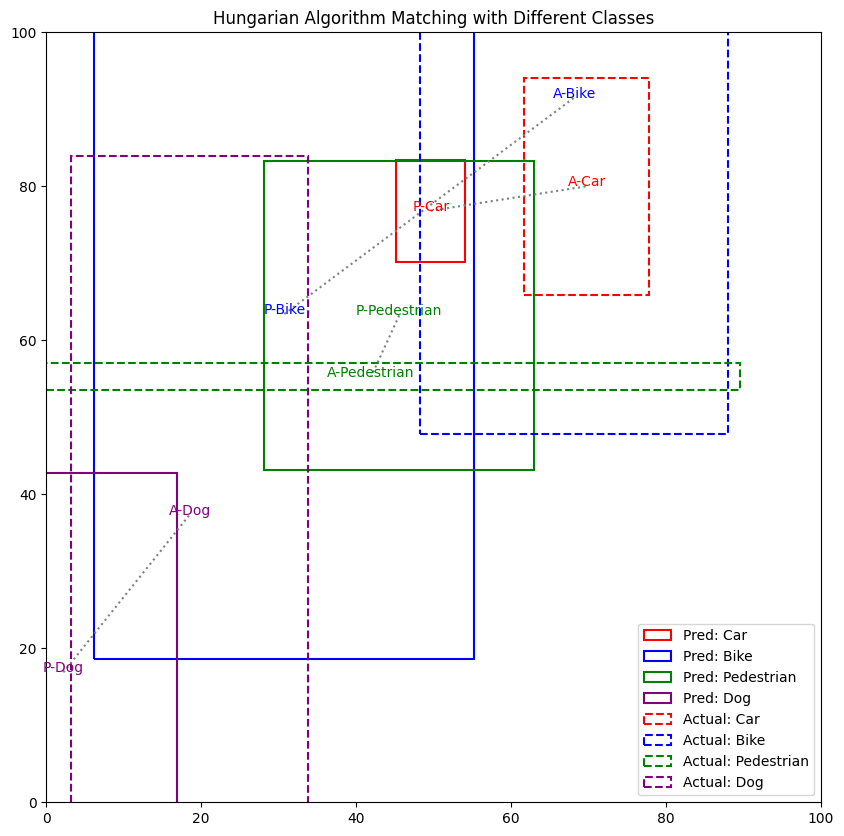

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import linear_sum_assignment

def box_cxcywh_to_xyxy(boxes):
    x_c, y_c, w, h = boxes.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

def generalized_box_iou(boxes1, boxes2):
    inter_x1 = torch.max(boxes1[:, None, 0], boxes2[:, 0])
    inter_y1 = torch.max(boxes1[:, None, 1], boxes2[:, 1])
    inter_x2 = torch.min(boxes1[:, None, 2], boxes2[:, 2])
    inter_y2 = torch.min(boxes1[:, None, 3], boxes2[:, 3])
    inter_area = (inter_x2 - inter_x1).clamp(min=0) * (inter_y2 - inter_y1).clamp(min=0)
    boxes1_area = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    boxes2_area = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    union_area = boxes1_area[:, None] + boxes2_area - inter_area
    return inter_area / union_area

class HungarianMatcher:
    def __init__(self, cost_class=1, cost_bbox=1, cost_giou=1):
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou

    def __call__(self, outputs, targets):
        out_bbox = outputs["pred_boxes"]
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)
        cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox), box_cxcywh_to_xyxy(tgt_bbox))
        C = self.cost_bbox * cost_bbox + self.cost_giou * cost_giou

        indices = linear_sum_assignment(C.cpu())
        return indices

# Set seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Define colors and classes
colors = ['red', 'blue', 'green', 'purple']
classes = ['Car', 'Bike', 'Pedestrian', 'Dog']

# Generate random boxes for 4 classes [center_x, center_y, width, height]
predicted_boxes = torch.rand(4, 4) * 100
actual_boxes = torch.rand(4, 4) * 100

outputs = {"pred_boxes": predicted_boxes}
targets = [{"boxes": actual_boxes}]

matcher = HungarianMatcher(cost_bbox=1, cost_giou=1)
indices = matcher(outputs, targets)

plt.figure(figsize=(10, 10))
ax = plt.gca()

# Plot predicted boxes with annotations
for i, (box, color) in enumerate(zip(predicted_boxes, colors)):
    rect = plt.Rectangle((box[0] - box[2] / 2, box[1] - box[3] / 2), box[2], box[3], linewidth=1.5, edgecolor=color, facecolor='none', label=f'Pred: {classes[i]}')
    ax.add_patch(rect)
    ax.text(box[0], box[1], f'P-{classes[i]}', color=color, ha='center')

# Plot actual boxes with annotations
for i, (box, color) in enumerate(zip(actual_boxes, colors)):
    rect = plt.Rectangle((box[0] - box[2] / 2, box[1] - box[3] / 2), box[2], box[3], linewidth=1.5, edgecolor=color, facecolor='none', linestyle='--', label=f'Actual: {classes[i]}')
    ax.add_patch(rect)
    ax.text(box[0], box[1], f'A-{classes[i]}', color=color, ha='center')

# Draw lines between matched boxes
for i, j in zip(*indices):
    pred_box = predicted_boxes[i]
    act_box = actual_boxes[j]
    plt.plot([pred_box[0], act_box[0]], [pred_box[1], act_box[1]], color='gray', linestyle=':', linewidth=1.5)

plt.xlim(0, 100)
plt.ylim(0, 100)
plt.title('Hungarian Algorithm Matching with Different Classes')
plt.legend()
plt.show()


# GIOU 计算

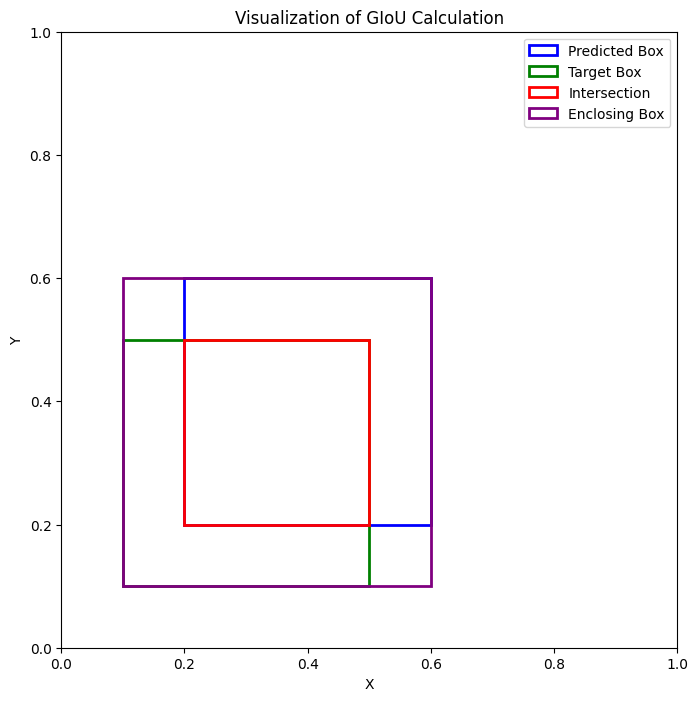

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_boxes(ax, boxes, color, label):
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor=color, facecolor='none', label=label)
        ax.add_patch(rect)

# Define the boxes in (x_min, y_min, x_max, y_max) format
pred_box = [0.2, 0.2, 0.6, 0.6]  # Predicted box
target_box = [0.1, 0.1, 0.5, 0.5]  # Target box

# Calculate the intersection and enclosing box
intersection = [max(pred_box[0], target_box[0]), max(pred_box[1], target_box[1]),
                min(pred_box[2], target_box[2]), min(pred_box[3], target_box[3])]
enclosing_box = [min(pred_box[0], target_box[0]), min(pred_box[1], target_box[1]),
                 max(pred_box[2], target_box[2]), max(pred_box[3], target_box[3])]

# Create a plot
fig, ax = plt.subplots(1, figsize=(8, 8))

# Draw the boxes
draw_boxes(ax, [pred_box], 'blue', 'Predicted Box')
draw_boxes(ax, [target_box], 'green', 'Target Box')
draw_boxes(ax, [intersection], 'red', 'Intersection')
draw_boxes(ax, [enclosing_box], 'purple', 'Enclosing Box')

# Set plot limits and labels
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.set_title('Visualization of GIoU Calculation')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()


# back——bone 相关，卷积

In [18]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.models import resnet50
from torchvision.ops.misc import FrozenBatchNorm2d

class BackboneBase(nn.Module):
    def __init__(self, backbone: nn.Module, train_backbone: bool, num_channels: int, return_interm_layers: bool):
        super().__init__()
        # 冻结指定层的参数
        for name, parameter in backbone.named_parameters():
            if not train_backbone or 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                parameter.requires_grad_(False)
        # 设置返回层
        if return_interm_layers:
            return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"} # for vis maybe
        else:
            return_layers = {'layer4': "0"}
        # 使用 IntermediateLayerGetter 获取指定层的输出
        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.num_channels = num_channels

    def forward(self, x):
        # 从骨干网络中提取特征
        features = self.body(x)
        return features

class Backbone(BackboneBase):
    def __init__(self, name: str, train_backbone: bool, return_interm_layers: bool, dilation: bool):
        # 获取 ResNet 骨干网络
        backbone = getattr(torchvision.models, name)(
            pretrained=True, norm_layer=FrozenBatchNorm2d,
            replace_stride_with_dilation=[False, False, dilation])
        # 设置通道数
        num_channels = 512 if name in ('resnet18', 'resnet34') else 2048
        # 初始化 BackboneBase
        super().__init__(backbone, train_backbone, num_channels, return_interm_layers)

# 使用示例
# 初始化一个 ResNet50 骨干网络，不训练骨干网络，返回所有中间层，不使用空洞卷积
detr_backbone = Backbone(name='resnet50', train_backbone=False, return_interm_layers=True, dilation=False)

# 创建一个假的输入张量，模拟一个批次中有一张 800x800 的 RGB 图像
input_tensor = torch.rand(1, 3, 800, 1333)

# 获取特征图
output_features = detr_backbone(input_tensor)

# 打印输出特征图的键和形状
for key, value in output_features.items():
    print(f"Layer {key} output shape: {value.shape}")


# We use scale augmentation, resizing the input images such that the shortest side is at least 480 and at most 800 pixels while the longest at most 1333 [50].
# 因此最后对应的特征图尺寸不会超过 50，embedding 是够用的

Layer 0 output shape: torch.Size([1, 256, 200, 334])
Layer 1 output shape: torch.Size([1, 512, 100, 167])
Layer 2 output shape: torch.Size([1, 1024, 50, 84])
Layer 3 output shape: torch.Size([1, 2048, 25, 42])


In [20]:
input_proj = nn.Conv2d(2048, 256, kernel_size=1)
res = input_proj(value)
print(f"{value.shape} -> {res.shape}")

torch.Size([1, 2048, 25, 42]) -> torch.Size([1, 256, 25, 42])


# query 相关的逻辑

In [1]:
from torch import nn
num_queries = 100
hidden_dim = 512
q_lay = nn.Embedding(num_queries, hidden_dim)

In [4]:
q_lay.weight.shape

torch.Size([100, 512])

# transformer: 多头注意机制

In [5]:
import torch
import torch.nn as nn

# 参数设置
d_model = 512  # 嵌入维度
nhead = 8       # 多头数量
dropout = 0.1   # Dropout 概率

# 初始化多头注意力层
multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)

# 模拟输入数据
L, N, E = 10, 5, 512  # 序列长度, 批大小, 嵌入维度
query = torch.rand(L, N, E)
key = value = torch.rand(L, N, E)  # 在自注意力场景中，key 和 value 通常相同

# 运行多头注意力机制
output, attn_weights = multihead_attn(query, key, value)

# 打印输出形状
print("Output shape:", output.shape)
print("Attention weights shape:", attn_weights.shape)


Output shape: torch.Size([10, 5, 512])
Attention weights shape: torch.Size([5, 10, 10])



d_model 通常指的就是在 Transformer 模型中使用的“隐藏尺寸”（hidden size）或者“模型维度”（model dimension）。这个参数定义了 Transformer 中各个子层以及嵌入层的维度。



\[
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\]
其中 \(d_k\) 是键向量的维度。这个归一化因子有助于梯度稳定性。


Q (Query): [w*h, bs, hidden_size]
K (Key): [w*h, bs, hidden_size]
V (Value): [w*h, bs, hidden_size]

经过一个投影之后，对应的权重成了 d_k

计算出来的 attention 前边半部分是：
[w*h,w*h,bs]
经过 soft max 归一化
和 v 头加权相乘之后得到结果： 
[w*h,bs,hidden_size]

![](https://lh-picbed.oss-cn-chengdu.aliyuncs.com/20240719215159.png)

每一个头意思就是一份独立的 qkv 的矩阵，拼接在一起，随后得到和原始大小一致的结果。

# 尺寸相关
hs.shape = [num_queries, hidden_dim, bs]


In [1]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model


def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=100, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--dataset_file', default='coco')
    parser.add_argument('--coco_path', type=str)
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=2, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
    return parser
parser = get_args_parser()
args = parser.parse_args(args=[])



In [2]:
args

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco', coco_path=None, coco_panoptic_path=None, remove_difficult=False, output_dir='', device='cuda', seed=42, resume='', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://')

In [3]:
model, criterion, postprocessors = build_model(args)

/home/lihao/miniconda3/envs/detr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lihao/miniconda3/envs/detr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
temp_tensor = torch.randn(1,3,448,448)
model(temp_tensor)

{'pred_logits': tensor([[[ 0.3168,  0.2996,  1.1350,  ...,  0.9839, -0.2085,  0.6042],
          [ 0.1370,  0.4937,  0.9698,  ...,  0.3775, -0.5161,  0.4802],
          [ 0.3774,  0.0749,  0.9778,  ...,  0.4421, -0.0503,  0.3240],
          ...,
          [ 0.2857, -0.0456,  0.9039,  ...,  0.0628, -0.6555,  0.3390],
          [ 0.4445, -0.2301,  0.9806,  ...,  0.5823, -0.7152,  0.3386],
          [ 0.2113, -0.4120,  0.5705,  ...,  0.3840, -0.7123,  0.2769]]],
        grad_fn=<SelectBackward0>),
 'pred_boxes': tensor([[[0.5215, 0.4745, 0.4700, 0.4910],
          [0.5241, 0.4859, 0.4769, 0.4928],
          [0.5168, 0.4822, 0.4801, 0.4928],
          [0.5259, 0.4873, 0.4763, 0.4994],
          [0.5107, 0.4868, 0.4944, 0.4922],
          [0.5154, 0.4777, 0.4713, 0.4970],
          [0.5150, 0.4746, 0.4889, 0.4937],
          [0.5258, 0.4957, 0.4835, 0.4901],
          [0.5048, 0.4732, 0.4800, 0.4839],
          [0.5080, 0.4959, 0.4877, 0.4872],
          [0.5090, 0.4907, 0.4876, 0.4903],
  